## Human Protein Multi Label Image Classification 

This is a starter notebook for the competition - https://www.kaggle.com/birajparikh16/simple-cnn-starter

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline

## Exploring the Data

When you create a notebook with the "Notebooks" tab of a Kaggle competition, the data is automatically included in the `../input` folder. You can explore the files in the sidebar. Let us create some constants acess the data directories and CSV files.

In [2]:
DATA_DIR = '../input/jovian-pytorch-z2g/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV = '../input/jovian-pytorch-z2g/submission.csv'   # Contains dummy labels for test image

The `train.csv` file contains image IDs and labels for training data. Note that this is a multi-label classification problem. Each image can have more than one type of protein.

In [3]:
!head "{TRAIN_CSV}"

Image,Label
19567,9
29993,6 4
17186,1 4
29600,6 2
701,3 4
26562,9
1080,4
27886,4
30721,6


Similarly, `submission.csv` contains image IDs for test data. However, since the goal of this competition is to make predictions for the test set, the `submission.csv` files contains **dummy labels**, which you need to replace with your predictions and sumbit to the competition on the "Submission" tab. In other words, we don't have the labels for the test set.

In [4]:
!head "{TEST_CSV}"

Image,Label
24117,0
15322,0
14546,0
8079,0
13192,0
25927,0
3372,0
21781,0
2847,0


The image files are named `<image-id>.png` and can be found in the respective `train` and `test` folders.

In [5]:
!ls "{TRAIN_DIR}" | head

0.png
1.png
10000.png
10001.png
10005.png
10008.png
10009.png
10012.png
10013.png
10014.png
ls: write error: Broken pipe


Let's load the `train.csv` file into a Pandas dataframe

In [6]:
train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


Let's also put the textual labels in a dictionary for later use.

In [7]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

To create a tensor from the labels, we will encode the labels as vectors of 1s & 0s. For example, if the labels are `'2 4 5'`, the correspoding vector for it would be `[0, 0, 1, 0, 1, 1, 0, 0, 0, 0]`. Let's define helper funtions to encode labels into tensors and vice versa.

In [8]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)
    

In [9]:
encode_label('2 4 5')

tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 0.])

In [10]:
decode_target(torch.tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0.]))

'2 4 5'

In [11]:
decode_target(torch.tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0.]), text_labels=True)

'Nucleoli(2) Nucleoplasm(4) Nucleoli fibrillar center(5)'

## Creating Datasets & Data Loaders

We can now create a custom dataset by extending the `Dataset` class from PyTorch. We need to define the `__len__` and `__getitem__` methods to create a dataset. We'll also provide the option of adding transforms into the constructor.

In [12]:
class HumanProteinDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

Transforms can be chained using `transforms.Compose`. For instance, you may add `transforms.Resize(128)` before `transforms.ToTensor()` to resize images to size 128x128 before converting them into tensors. See the full list of transforms here: https://pytorch.org/docs/master/torchvision/transforms.html

In [13]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = HumanProteinDataset(TRAIN_CSV, TRAIN_DIR, transform=transform)

Let's check how many samples the dataset contains

In [14]:
len(dataset)

19236

Let's take a look at a sample image from the dataset. We'll define a function `show_sample` to help us. We will also include the option to invert the image before showing it, because the original images are quite dark.

In [15]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))
    

Here's a sample image without the colors inverted.

Labels: Nuclear speckles(9)


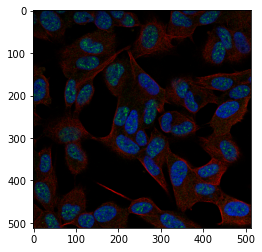

In [16]:
show_sample(*dataset[0], invert=False)

Here's the same image viewed with the colors inverted

Labels: Nuclear speckles(9)


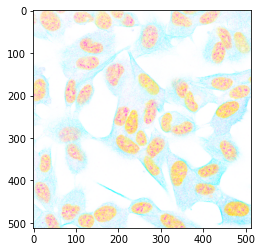

In [17]:
show_sample(*dataset[0])

### Training & Validation sets

As a good practice, we should split the data into training and validation datasets. Let's fix a seed for PyTorch (to ensure we always get the same validation set), and create the datasets using `random_split`.

In [18]:
torch.manual_seed(10)

I'm using a validation percentage of 10%, but you can use a smaller or larger percentage. One good strategy is to determine a good set of hyperparameters, and then retrain on a smaller validation set for your final submission.

In [19]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [20]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(17313, 1923)

### Data Loaders

In [21]:
batch_size = 64

In [22]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [23]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

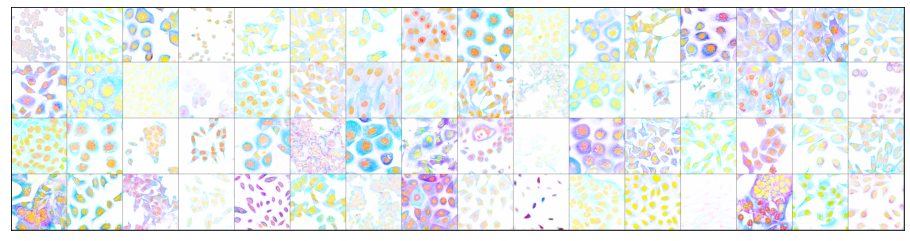

In [24]:
show_batch(train_dl)

## Model

In [25]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [26]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_score']))

In [27]:
class ProteinCnnModel(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(), 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Sigmoid()
        )
        
    def forward(self, xb):
        return self.network(xb)

In [34]:
class ProteinCnnModel2(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [29]:
model = ProteinCnnModel2()
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


ProteinCnnModel2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [30]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [31]:
device = get_default_device()
device

device(type='cuda')

In [32]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [35]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([64, 3, 512, 512])
out.shape: torch.Size([64, 10])
out[0]: tensor([0.7446, 0.5123, 0.2677, 0.6550, 0.4260, 0.4315, 0.4389, 0.4434, 0.4063,
        0.6774], device='cuda:0', grad_fn=<SelectBackward>)


If your kernel runs out of memory here, you might need to reduce your batch size.

## Training the model

In [36]:
from tqdm.notebook import tqdm

In [37]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [38]:
model = to_device(ProteinCnnModel2(), device)

In [39]:
evaluate(model, val_dl)

{'val_loss': 0.7440828084945679, 'val_score': 0.2113644927740097}

In [40]:
num_epochs = 2
opt_func = torch.optim.Adam
lr = 1e-2

In [41]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 0.3768, val_loss: 0.5166, val_score: 0.2355



Epoch [1], train_loss: 0.3464, val_loss: 0.3395, val_score: 0.4133


## Making predictions & submission

To start with, let's create a helper function to make a prediction on a single image.

In [42]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

Next, let's create a test dataset using the `submission.csv` file. Note that the file contains dummy labels (always `'0'`). We'll use the same transforms we used for the training set.

In [43]:
test_dataset = HumanProteinDataset(TEST_CSV, TEST_DIR, transform=transform)

In [44]:
img, target = test_dataset[0]
img.shape

torch.Size([3, 512, 512])

Let's try predicting the labels for some sample images

Prediction:  tensor([0.0843, 0.0714, 0.1734, 0.0891, 0.6226, 0.0325, 0.5248, 0.2662, 0.0490,
        0.0516], device='cuda:0', grad_fn=<SelectBackward>)
Labels: Nucleoplasm(4) Cytosol(6)


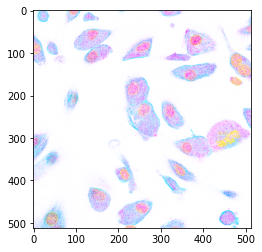

In [45]:
predict_single(test_dataset[100][0])

Prediction:  tensor([0.1089, 0.0882, 0.1512, 0.1195, 0.4987, 0.0412, 0.3521, 0.1507, 0.0651,
        0.0490], device='cuda:0', grad_fn=<SelectBackward>)
Labels: 


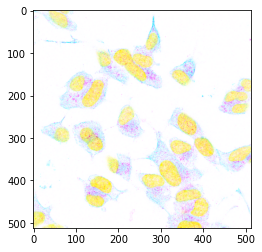

In [46]:
predict_single(test_dataset[74][0])

## Creating a submission file

In [47]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=2, pin_memory=True), device)

In [48]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [49]:
test_preds = predict_dl(test_dl, model)

Let us know create a submission file with these predictions

In [50]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.head()

,Image,Label
0,24117,2 4
1,15322,4
2,14546,
3,8079,
4,13192,4


We can now save it batck to CSV, and download the file from the sidebar (check the output folder)

In [51]:
sub_fname = 'resnet34_submission.csv'

In [52]:
submission_df.to_csv(sub_fname, index=False)

You can now upload this submission file here: https://www.kaggle.com/c/jovian-pytorch-z2g/submit

## Save to Jovian

In [53]:
!pip install jovian --upgrade

     |████████████████████████████████| 94 kB 1.7 MB/s eta 0:00:011
  Created wheel for uuid: filename=uuid-1.30-py3-none-any.whl size=6500 sha256=a0018efb023e9badb7c794376a1da393729b4b17ea864d9457f5409821aa7ff2
  Stored in directory: /root/.cache/pip/wheels/2a/ea/87/dd57f1ecb4f0752f3e1dbf958ebf8b36d920d190425bcdc24d
Successfully built uuid


In [54]:
import jovian

<IPython.core.display.Javascript object>

In [55]:
jovian.commit(project='zerogans-protein-competition')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/aakashns/zerogans-protein-competition


<IPython.core.display.Javascript object>

You can also use the "Save Version" button on Kaggle itself, to save a copy on your Kaggle profile.